The `normal_categories` ('rec.autos', 'rec.motorcycles', 'sci.electronics') are used for training the autoencoder. Documents from `anomaly_category` ('rec.sport.baseball') will be treated as anomalies during evaluation. We take all available training data for normal categories and a small, fixed number of samples (5) for the anomaly category to simulate a rare anomaly scenario. Test data is also fetched for evaluation.

In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd

# Define categories
normal_categories = ['rec.autos', 'rec.motorcycles', 'sci.electronics']
anomaly_category = ['rec.sport.baseball']

# Load normal data (train set)
normal_data = fetch_20newsgroups(subset='train', categories=normal_categories, remove=('headers', 'footers', 'quotes'))

# Load anomaly data (only 5 files)
anomaly_data_full = fetch_20newsgroups(subset='train', categories=anomaly_category, remove=('headers', 'footers', 'quotes'))
anomaly_data = anomaly_data_full.data[:5]  # Take just 5 examples

# Combine normal and anomaly texts
all_data = normal_data.data + anomaly_data

# Create labels: 0 = normal, 1 = anomaly
labels = np.concatenate([
    np.zeros(len(normal_data.data)),   # 0 for normal
    np.ones(len(anomaly_data))         # 1 for anomaly
])
df_final = pd.DataFrame({
    'content': all_data,
    'label': labels
})


In [2]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd

# Define categories
normal_categories = ['rec.autos', 'rec.motorcycles', 'sci.electronics']
anomaly_category = ['rec.sport.baseball']

# Load normal test data
normal_data_test = fetch_20newsgroups(subset='test', categories=normal_categories, remove=('headers', 'footers', 'quotes'))

# Load anomaly test data (we want only 5 files)
anomaly_data_test_full = fetch_20newsgroups(subset='test', categories=anomaly_category, remove=('headers', 'footers', 'quotes'))
anomaly_data_test = anomaly_data_test_full.data[:5]  # Take just 5 examples

# Combine normal and anomaly texts
all_test_data = normal_data_test.data + anomaly_data_test

# Create labels: 0 = normal, 1 = anomaly
labels_test = np.concatenate([
    np.zeros(len(normal_data_test.data)),  # Normal
    np.ones(len(anomaly_data_test))        # Anomaly (5 only)
])

# Final test DataFrame
df_test = pd.DataFrame({
    'content': all_test_data,
    'label': labels_test
})


## 2. Text Embedding with SBERT

We use the `SentenceTransformer` library with the `all-mpnet-base-v2` model to convert the text data from both normal and anomalous categories into dense vector embeddings (768 dimensions). These embeddings capture the semantic meaning of the text.

In [ ]:
# Install the sentence-transformers library if not already installed
%pip install sentence-transformers

# Import SentenceTransformer
from sentence_transformers import SentenceTransformer

# Ensure PyTorch is using the GPU
import torch

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the model and encode the texts
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

# Encode the data with the GPU
embeddings = model.encode(all_data, show_progress_bar=True, device=device)
embeddings_test = model.encode(all_test_data, show_progress_bar=True, device=device)



In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.12.0


Autoencoder Architecture: 

- Encoder: Input (768-dim) -> Dense(256, ReLU) -> Dense(32, ReLU)
- Decoder: Dense(32, ReLU) -> Dense(256, ReLU) -> Dense(768, Sigmoid) 

Epoch 1/100
7/7 [==============================] - 1s 36ms/step - loss: 1.2130 - val_loss: 1.1470
Epoch 2/100
7/7 [==============================] - 0s 21ms/step - loss: 1.0611 - val_loss: 1.0131
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 0.9977 - val_loss: 1.0083
Epoch 4/100
7/7 [==============================] - 0s 26ms/step - loss: 0.9953 - val_loss: 1.0053
Epoch 5/100
7/7 [==============================] - 0s 20ms/step - loss: 0.9921 - val_loss: 1.0023
Epoch 6/100
7/7 [==============================] - 0s 21ms/step - loss: 0.9891 - val_loss: 0.9996
Epoch 7/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9861 - val_loss: 0.9966
Epoch 8/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9830 - val_loss: 0.9941
Epoch 9/100
7/7 [==============================] - 0s 19ms/step - loss: 0.9801 - val_loss: 0.9911
Epoch 10/100
7/7 [==============================] - 0s 20ms/step - loss: 0.9769 - val_loss: 0.9884
Epoch 11/100
7/7 [=

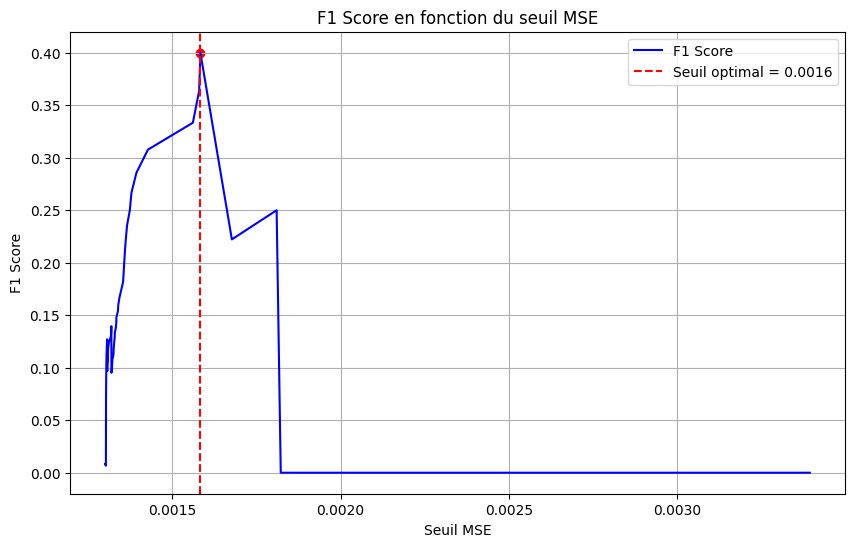

 Meilleur seuil MSE : 0.0016
Meilleur F1 score  : 0.4000
Confusion Matrix:
 [[1184    3]
 [   3    2]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU


with tf.device('/GPU:0'):

  x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(encoder_input)


  scaler = StandardScaler()
  embeddings_scaled = scaler.fit_transform(embeddings[df_final["label"].values == 0])
  embeddings_test_scaled = scaler.transform(embeddings_test)

  x_train = embeddings_scaled
  x_test = embeddings_test_scaled



  input_dim = x_train.shape[1]



  encoder_input = Input(shape=(input_dim,))
  x = Dense(256, activation='relu')(encoder_input)
  # x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(encoder_input)

  # x = Dense(256)(encoder_input)
  # x = LeakyReLU()(x)
  # encoded = Dense(64)(x)  # Experiment with latent space size

  encoded = Dense(32, activation='relu')(x)

  x = Dense(256, activation='relu')(encoded)
  decoded = Dense(input_dim, activation='sigmoid')(x)

  autoencoder = Model(encoder_input, decoded)

  autoencoder.compile(optimizer='adam', loss='mse')


  history_noisy = autoencoder.fit(x_train, x_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))


  encoder = Model(encoder_input, encoded)



  encoded_data = encoder.predict(x_test)

  y_true = df_test["label"].values.copy()
  y_true[y_true == 1] = 1
  y_true[y_true == 0] = 0





sorted_mse = np.sort(mse)
f1_scores = []

# 2. Calculer le F1-score pour chaque seuil potentiel
for thresh in sorted_mse:
    y_pred = np.where(mse > thresh, 1, 0)  # 1 = anomalie, 0 = normal
    f1 = f1_score(y_true, y_pred)
    f1_scores.append(f1)

# 3. Trouver le meilleur seuil
best_idx = np.argmax(f1_scores)
best_thresh = sorted_mse[best_idx]
best_f1 = f1_scores[best_idx]

# 4. Tracer la courbe F1 vs MSE-threshold
plt.figure(figsize=(10, 6))
plt.plot(sorted_mse, f1_scores, color='blue', label="F1 Score")
plt.axvline(best_thresh, color='red', linestyle='--', label=f"Seuil optimal = {best_thresh:.4f}")
plt.scatter([best_thresh], [best_f1], color='red')
plt.title("F1 Score en fonction du seuil MSE")
plt.xlabel("Seuil MSE")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()

# 5. Résultats
print(f" Meilleur seuil MSE : {best_thresh:.4f}")
print(f"Meilleur F1 score  : {best_f1:.4f}")
y_pred = np.where(mse > best_thresh, 1, 0)
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_mat)




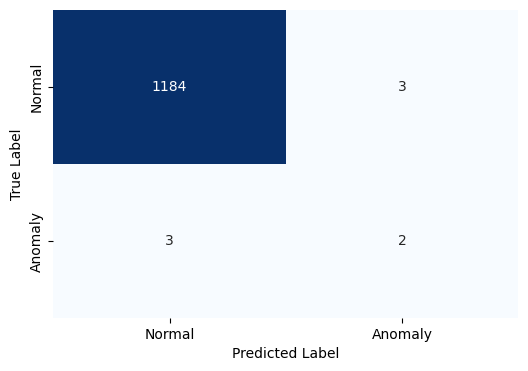

In [4]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Static variables
best_thresh = 0.0016
best_f1 = 0.4000
conf_mat = np.array([[1184, 3], [3, 2]])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.title(f'Confusion Matrix\nBest Threshold: {best_thresh}, Best F1 Score: {best_f1}')
plt.show()

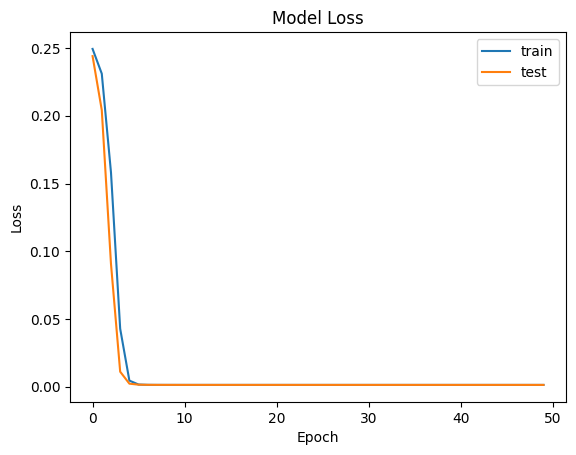

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_noisy.history['loss'], label='train')
plt.plot(history_noisy.history['val_loss'], label='test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

1st test training autoencoder 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization
from tensorflow.keras.models import Model


with tf.device('/GPU:0'):
  x_train = embeddings[df_final["label"].values == 0]
  x_test = embeddings_test




  input_dim = x_train.shape[1]


  # Input layer
  encoder_input = Input(shape=(input_dim,))

  # Encoder
  x = Dense(512, activation='gelu')(encoder_input)
  x = LayerNormalization()(x)

  x = Dense(256, activation='gelu')(x)
  x = LayerNormalization()(x)

  x = Dense(128, activation='gelu')(x)
  x = LayerNormalization()(x)

  encoded = Dense(32, activation='gelu')(x)
  x = LayerNormalization()(encoded)

  # Decoder
  x = Dense(128, activation='gelu')(x)
  x = LayerNormalization()(x)

  x = Dense(256, activation='gelu')(x)
  x = LayerNormalization()(x)

  x = Dense(512, activation='gelu')(x)
  x = LayerNormalization()(x)

  decoded = Dense(input_dim)(x)

  # Autoencoder model
  autoencoder = Model(encoder_input, decoded)

  # encoder_input = Input(shape=(input_dim,))
  # x = Dense(256, activation='gelu')(encoder_input)
  # tf.keras.layers.LayerNormalization()
  # x = Dense(256, activation='gelu')(encoder_input)
  # encoded = Dense(32, activation='gelu')(x)
  # tf.keras.layers.LayerNormalization()




  # x = Dense(256, activation='gelu')(encoded)
  # #
  # decoded = Dense(input_dim)(x)


  # autoencoder = Model(encoder_input, decoded)

  autoencoder.compile(optimizer='Adamax', loss='mse')


  history_noisy = autoencoder.fit(x_train, x_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))


  encoder = Model(encoder_input, encoded)



  encoded_data = encoder.predict(x_test)

  y_true = df_test["label"].values.copy()
  y_true[y_true == 1] = 1
  y_true[y_true == 0] = 0




In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict reconstruction
reconstructions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - reconstructions, 2), axis=1)

# Choose a threshold (e.g., 95th percentile)
threshold = np.percentile(mse, 95)

# Predict anomaly if MSE > threshold
y_pred = (mse > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

38/38 [==============================] - 0s 5ms/step
Confusion Matrix:
[[1131   56]
 [   1    4]]
F1 Score: 0.12307692307692308


In [ ]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_true})
error_df.describe()



38/38 [==============================] - 0s 2ms/step


,reconstruction_error,true_class
count,1192.000000,1192.000000
mean,0.001315,0.004195
std,0.000170,0.064657
min,0.001301,0.000000
25%,0.001302,0.000000
50%,0.001302,0.000000
75%,0.001302,0.000000
max,0.006063,1.000000


avec *100* epochs et edit sur le layer 2

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Precision: 0.4000
Recall: 0.4000


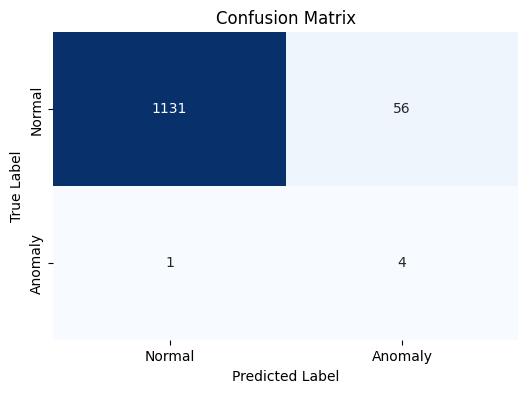

In [16]:

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()